# $SU(2)$ Benchmarking

$SU(2)$ benchmarking is a QCVV routine that can measure the two qubit gate fidelity independently of
any additional single qubit gate errors. To demonstrate this, we define a noise model which applies
single qubit bit-flip errors and two qubit depolarising errors.


In [1]:
import cirq
from __future__ import annotations

In [2]:
class IndependentNoiseModel(cirq.NoiseModel):
    "Applies single and two qubit noise channels independently"

    def __init__(self, single_qubit_error: float, two_qubit_error: float) -> None:
        super().__init__()
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        self.single_qubit_error_channel = cirq.BitFlipChannel(p=single_qubit_error)
        self.two_qubit_error_channel = cirq.DepolarizingChannel(
            p=15 / 16 * two_qubit_error, n_qubits=2
        )

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.OP_TREE]:
        if len(operation.qubits) == 1:
            return [operation, self.single_qubit_error_channel(*operation.qubits)]
        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_error_channel(*operation.qubits)]
        return [operation]


TWO_QUBIT_ERROR = 0.02
SINGLE_QUBIT_ERROR = 0.005
noise = IndependentNoiseModel(
    single_qubit_error=SINGLE_QUBIT_ERROR, two_qubit_error=TWO_QUBIT_ERROR
)
simulator = cirq.DensityMatrixSimulator(noise=noise)

We now run the experiment for a CNOT gate


Building circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Estimated two qubit gate fidelity: 0.9792 +/- 0.00021519
Estimated single qubit noise: 0.30306 +/- 0.0034248



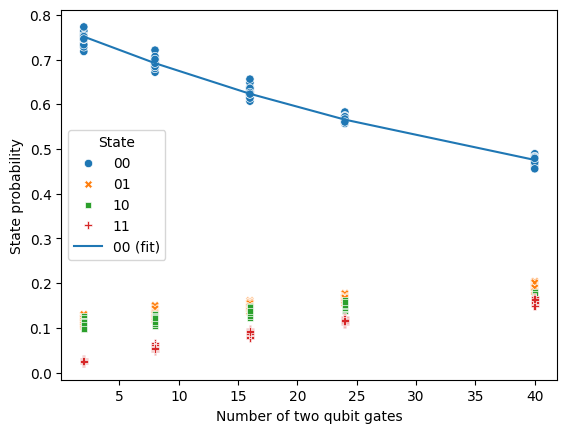

In [3]:
from supermarq.qcvv import SU2

experiment = SU2(20, [1, 4, 8, 12, 20], two_qubit_gate=cirq.CNOT)
results = experiment.run_with_simulator(simulator=simulator)
results.analyze()

If we then compare the output results we see that the experiment has accurately estimated the two
qubit gate error.


In [4]:
print(
    f"Estimated two qubit gate error: {results.two_qubit_gate_error:.4f} +/ {results.two_qubit_gate_error_std:.4f}"
)
print(f"True two qubit gate error: {TWO_QUBIT_ERROR:.4f}")

Estimated two qubit gate error: 0.0208 +/ 0.0002
True two qubit gate error: 0.0200


Finally we can check the accuracy of the single qubit noise estimate. The estimate provided by the
results object is the total single qubit noise, so to estimate the single qubit gate noise we divide
by the number of single qubit gates (which is constant across all circuits in SU2 benchmarking).
This can then be compared to the known single qubit gate error in our simulation. Note that our
noise model contains a bit-flip channel with average error $p$. The corresponding depolarising error
is $\tfrac{3}{4}p$, which we compare to the estimate above.


In [5]:
num_1q_gates = len(
    list(experiment.samples[0].circuit.findall_operations(lambda x: x.gate.num_qubits() == 1))
)
estimated_single_qubit_gate_depolarising_error = results.single_qubit_noise / num_1q_gates
estimated_single_qubit_gate_depolarising_error_std = results.single_qubit_noise_std / num_1q_gates
print(
    "Estimated single qubit depolarising error: "
    f"{estimated_single_qubit_gate_depolarising_error:.4f} +/ "
    f"{estimated_single_qubit_gate_depolarising_error_std:.4f}"
)
print(f"True single qubit depolarising error: {3/4 * SINGLE_QUBIT_ERROR:.4f}")

Estimated single qubit depolarising error: 0.0037 +/ {estimated_single_qubit_gate_depolarising_error_std:.4f}
True single qubit depolarising error: 0.0037
